## Imports

In [1]:
"""
Machine Learning Exercise 1
"""
import os
import sys

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.display import Image
from six import StringIO
from sklearn import tree, metrics
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

## Base class tha is used by the other exercises.

In [2]:
class ExerciseBase(object):
    """Base Exercise Class"""
    DATASET_FILE_PATH = 'day.csv'

    def __init__(self, dataset_path=None):
        """
        :param dataset_path: path to the dataset file, defaults to DATASET_FILE_PATH
        """
        self.dataset_path = dataset_path if dataset_path else self.DATASET_FILE_PATH
        self.data, self.target = self._parse_data()
        self._estimator = None
        self._data_train = None
        self._data_test = None
        self._target_train = None
        self._target_test = None

    def _parse_data(self):
        """
        Data inside the file:
        - instant: record index
        - dteday : date
        - season : season (1:springer, 2:summer, 3:fall, 4:winter)
        - yr : year (0: 2011, 1:2012)
        - mnth : month ( 1 to 12)
        - holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
        - weekday : day of the week
        - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
        + weathersit :
            - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
            - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
        - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
        - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
        - hum: Normalized humidity. The values are divided to 100 (max)
        - windspeed: Normalized wind speed. The values are divided to 67 (max)
        - casual: count of casual users
        - registered: count of registered users
        - cnt: count of total rental bikes including both casual and registered

        Reads the dataset file. Drops the columns instance, dteday, casual and registered from the DataFrame,
        since they will add noise to the dataset:
            - instance is a simple id index that does not offer any information
            - casual + registered result in cnt, so we are basically cheating
            - dteday is already in the data in the form of yr, mnth, weekday
        The yr column could also be dropped, because it intuitively should not affect the result,
        however it is kept since that it is not certain.
        Separates the data into the x (data) and y (target)

        :rtype: pd.DataFrame
        """
        df = pd.read_csv(self.dataset_path)
        target = df["cnt"]
        df = df.drop(columns=['instant', 'dteday', 'casual', 'registered', "cnt"])
        return df, target

    def __str__(self):
        return f"ExerciseBase(dataset_path={self.dataset_path})"

    def _split_data(self, test_size=0.35, random_state=0, stratify=False):
        """
        The training phase.
        :param test_size:
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split.
        If int, represents the absolute number of test samples.
        If None, the value is set to the complement of the train size.
        If train_size is also None, it will be set to 0.25.
        :param random_state: Controls the shuffling applied to the data before applying the split.
        Pass an int for reproducible output across multiple function calls
        :param stratify: If True, data is split in a stratified fashion, using the target data as the class labels.
        :return: A tuple that with the test_data and target_test
        """
        # split the data into the training set and the test set
        self._data_train, self._data_test, self._target_train, self._target_test = \
            train_test_split(self.data,
                             self.target,
                             test_size=test_size,
                             random_state=random_state,
                             stratify=self.target if stratify else None)

    def train(self, *args):
        """
        Trains the model
        Not Implemented for the Base class Must be overriden
        """
        raise NotImplementedError

    def predict(self, *args):
        """
        Makes the prediction
        Not Implemented for the Base class Must be overriden
        """
        raise NotImplementedError

## Class for Question 1 a

In [3]:
class Exercise1A(ExerciseBase):
    """ Question 1A """
    CLASSES = 10

    def __init__(self, dataset_path=None, classes=None):
        """
        :param dataset_path: path to the dataset file, defaults to DATASET_FILE_PATH
        :param classes: the number of classes to split the cnt value into
        """
        super(Exercise1A, self).__init__(dataset_path)
        self.classes = classes if classes else self.CLASSES

        self._labels = None

    def __str__(self):
        return f"Exercise1A(dataset_path={self.dataset_path})"

    def _generate_cnt_classes(self):
        """
         Because this is a classification problem, we need to generate the number of classes.
         So the target is split into classes.
        """
        max_value = round(self.target.max(), -3)  # round to the nearest 1000
        step = max_value // self.classes
        bins = [i for i in range(0, max_value + step, step)]  # create the bins up to max value
        self._labels = [f"[{bins[i]} {bins[i + 1]}]" for i in range(0, len(bins) - 1)]  # used for visualizing the tree
        print(f"Classes used for binary classification: {self._labels}")
        self.target = pd.cut(self.target, labels=False, precision=0, bins=bins)

    def _find_estimator(self):
        """
         Finds the best DecisionTreeClassifier classifier using GridSearchCV.
        """

        # the classifier
        dec_tree = tree.DecisionTreeClassifier()

        param_grid = {"criterion": ['gini', 'entropy'],
                      "max_depth": range(1, 10),
                      "min_samples_split": range(2, 10),
                      "min_samples_leaf": range(1, 5)
                      }

        clf_gs = GridSearchCV(dec_tree, param_grid=param_grid, n_jobs=4)

        # Fitting the grid search
        clf_gs.fit(self._data_train, self._target_train)

        # Viewing The Best Parameters
        print('Best Parameters: ', clf_gs.best_params_)
        print('Best Accuracy Score Achieved in Grid Search: ', clf_gs.best_score_)
        self._estimator = clf_gs.best_estimator_

    def train(self):
        """
        Trains the model
        """
        self._split_data(stratify=True)
        self._find_estimator()
        self._estimator.fit(self._data_train, self._target_train)

    def predict(self):
        """
        Makes the prediction given the data test and target test data.

        :returns: The predicted classes, or the predict values.
        """
        return self._estimator.predict(self._data_test)

    def visualize_tree(self):
        """
        Visualizes the created tree. It requires that the tree is trained first.
        """
        dot_data = tree.export_graphviz(self._estimator,
                                        feature_names=self.data.columns.values.tolist(),
                                        class_names=self._labels,
                                        filled=True, rounded=True,
                                        special_characters=True)
        # Draw graph
        graph = graphviz.Source(dot_data)
        # Save to a file in the current directory
        graph.render("1_a_decision_tree_graphivz", format='png',
                     directory=os.path.join(os.getcwd(), 'images'))

    def feature_importance(self):
        """
        Provided that the model is trained, returns the feature importance in descending order.
        :rtype: [('feature_name', importance)]
        """
        feature_importance = list(zip(self.data.columns, self._estimator.feature_importances_))
        feature_importance.sort(key=lambda x: x[1], reverse=True)
        return feature_importance

    def report(self, target_test_predictions):
        """
        :param target_test_predictions: the prediction on test data
        :return: the same as the  metrics.classification_report
        """
        accuracy = metrics.accuracy_score(self._target_test, target_test_predictions)
        print('Accuracy: ', accuracy)
        return metrics.classification_report(self._target_test, target_test_predictions)

    @classmethod
    def create(cls, dataset_path=None, classes=None):
        """
        :param dataset_path: path to the dataset file, defaults to DATASET_FILE_PATH
        :param classes: the number of classes to split the cnt value into
        """
        exercise_1a = cls(dataset_path=dataset_path, classes=classes)
        exercise_1a._generate_cnt_classes()
        return exercise_1a

## Main function of Question 1 a

In [4]:
def main_ex_1a(classes, dataset_path):
    """
    Execution of Exercise 1 a
    :param classes: number of classes to split the data into
    :param dataset_path: path to the scv file that contains the dataset
    :returns: The two most prominent features that will be used in the next exercise
    :rtype: [self.data[most_important_feature_1], self.data[most_important_feature_2]]
    """
    ex_1a = Exercise1A.create(classes=classes, dataset_path=dataset_path)
    ex_1a.train()
    ex_1a.visualize_tree()
    target_test_predictions = ex_1a.predict()
    feature_importance = ex_1a.feature_importance()
    print(f'Feature Importance: {feature_importance}\n')
    print(ex_1a.report(target_test_predictions))
    return [ex_1a.data[feature_importance[0][0]], ex_1a.data[feature_importance[1][0]]]

##  Class for Question 1 b

In [5]:
class Exercise1B(ExerciseBase):
    """ Question 1B """

    def __init__(self, dataset_path=None):
        """
        :param dataset_path: path to the dataset file, defaults to DATASET_FILE_PATH
        """
        super(Exercise1B, self).__init__(dataset_path)
        self._partial_estimator = None
        self._prominent_features_1a = None

    def __str__(self):
        return f"Exercise1B(dataset_path={self.dataset_path})"

    def _transform_data(self):
        """
        Transforms the data so they can be used for linear regression.
        """
        self.data = self.data.values[:, :]
        self.target = self.target.values[:]

    def _train_with_alpha_(self, alpha):
        """
         Trains the model using Stochastic Gradient Descent algorithm given the hyperparameter alpha

         :param alpha: Constant that multiplies the regularization term. The higher the value, the stronger
         the regularization. Also used to compute the learning rate when set to learning_rate is set to ‘optimal’.
         :returns: a tuple of the score and the classifier, so the optimal one can be chosen
        """

        # the classifier
        grad_desc = SGDRegressor(alpha=alpha,
                                 learning_rate='optimal',
                                 loss='epsilon_insensitive',
                                 penalty='l1',
                                 verbose=1,
                                 max_iter=100000)

        # Used Grid Search in order to find the best, loss, penalty and learning rate hyperparameters
        # param_dict = {
        #     'alpha': list(10.0 ** -np.arange(1, 4)) + list(10.0 ** -np.arange(1, 4) * 3),
        #     'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
        #     'penalty': ['l2', 'l1', 'elasticnet'],
        #     'learning_rate': ['constant', 'optimal', 'invscaling'],
        # }
        # clf_gs = GridSearchCV(grad_desc, param_grid=param_dict, n_jobs=4, scoring='r2')
        #
        # # Fitting the grid search
        # clf_gs.fit(self._data_train, self._target_train)
        #
        # # Viewing The Best Parameters
        # print('Best Parameters: ', clf_gs.best_params_)
        # print('Best Score Achieved in Grid Search: ', clf_gs.best_score_)
        # self._estimator = clf_gs.best_estimator_

        # Used a much more iterations than needed in order to plot the figures for different alpha values
        # since for large alphas such as 0.1 and 0.01 the algorithm did not converge for less iterations,
        # because the algorithm moves away from local minima.
        # However for a smaller alpha 0.001 and 2000 iterations the algorithm converged almost every time and its score
        # was close to 0.8. Smaller values of alpha such as 0.0001 and 0.00001 were used but they did not improve the
        # score significantly and would require a lot of iterations. For alpha = 0.00001 the score was lower than of
        # the one with 0.001. Therefore 0.001 proved to be the best alpha in terms of both cost and score.

        # scale that data
        scaler = StandardScaler()
        scaler.fit(self._data_train)

        self._data_train = scaler.transform(self._data_train)
        self._data_test = scaler.transform(self._data_test)

        old_stdout = sys.stdout
        sys.stdout = my_stdout = StringIO()
        grad_desc.fit(self._data_train, self._target_train)
        sys.stdout = old_stdout
        loss_history = my_stdout.getvalue()
        loss_list = []
        for line in loss_history.split('\n'):
            if len(line.split("loss: ")) == 1:
                continue
            loss_list.append(float(line.split("loss: ")[-1]))
        print('Grad Desc Parameters: ', grad_desc.get_params())
        score = grad_desc.score(self._data_train, self._target_train)
        print(f'Score: {score}\n')
        plt.figure()
        plt.plot(np.arange(len(loss_list)), loss_list)
        plt.xlabel("Time in epochs")
        plt.ylabel("Loss")
        plt.savefig(os.path.join('images', f'1_b_epoch_loss_with_alpha_{alpha}.png'))
        plt.show()
        plt.close()
        return score, grad_desc

    def prominent_feature_sgl_inst_err_pred(self, epochs=15):
        """
        Performs single instance prediction using the most prominent feature from 1A.
        :param epochs: number of epochs that will be used, defaults to 15
        :type epochs: int
        """

        # the learning rate must be kept constant
        learning_rate = 0.1

        # x will be an instance from the most prominent feature
        most_prominent_feature = self._prominent_features_1a[0]
        # we need to reshape the data since x needs to be 2 dimensional
        x_instance = most_prominent_feature[:1].values.reshape(-1, 1)
        y_target = self.target[:1]

        sgd = SGDRegressor(loss="squared_loss",
                           learning_rate='constant',
                           eta0=learning_rate, penalty=None,
                           average=False,
                           random_state=42,
                           verbose=1)
        p_sum = []  # this holds the sum of y-y_hat of the instance
        coef_list = []  # this holds the coefficient values

        old_stdout = sys.stdout
        sys.stdout = my_stdout = StringIO()

        for epoch in range(epochs):
            model = sgd.partial_fit(x_instance, y_target)
            y_predicted = model.predict(x_instance)
            coef_list.append(model.coef_.tolist())
            print(f"Coeficient: {model.coef_} over epoch: {epoch}")
            e_p_sum = np.sum(y_target - y_predicted)
            p_sum.append(e_p_sum)
            print(f"Prediction: {y_predicted}, target: {y_target}, y-y': {e_p_sum} over epoch: {epoch}")

        print(f"Coeficients: {coef_list}\n")

        sys.stdout = old_stdout
        loss_history = my_stdout.getvalue()
        loss_list = []
        for line in loss_history.split('\n'):
            if len(line.split("loss: ")) == 1:
                continue
            loss_list.append(float(line.split("loss: ")[-1]))

        plt.figure()
        plt.plot(p_sum, loss_list)
        plt.scatter(p_sum, loss_list)
        plt.scatter(p_sum[:1], loss_list[:1], color='red')
        plt.xlabel(r"$y-\hat{y}$")
        plt.ylabel("Loss")
        plt.savefig(os.path.join('images', f'1b_y_y\'_for_{epochs}_epochs.png'))
        plt.show()
        plt.close()

    def train(self):
        """ Trains the models """
        self._split_data()
        # choose alpha from [0.1, 0.01, 0.001]
        best_estimator = None
        best_score = -10000
        # choose the best estimator, based on score
        for alpha in list(10.0 ** -np.arange(1, 4)):
            score, estimator = self._train_with_alpha_(alpha=alpha)
            if score > best_score:
                best_score = score
                best_estimator = estimator
        self._estimator = best_estimator

    def predict(self):
        """
        Makes the prediction given the data test and target test data.

        :returns: The predicted classes, or the predict values.
        """
        return self._estimator.predict(self._data_test)

    @classmethod
    def create(cls, prominent_features, dataset_path=None):
        """
        :param dataset_path: path to the dataset file, defaults to DATASET_FILE_PATH
        :param prominent_features: The two most prominent features that from 1A
        :type prominent_features: [Series(most_important_feature_1), Series(most_important_feature_2)]
        """
        exercise_1b = cls(dataset_path=dataset_path)
        exercise_1b._prominent_features_1a = prominent_features
        exercise_1b._transform_data()
        return exercise_1b

## Main function of Question 1 b

In [6]:
def main_ex_1b(dataset_path, prominent_features, epochs):
    """
    Execution of Exercise 1 b
    :param dataset_path: path to the scv file that contains the dataset
    :param prominent_features: The two most prominent features that from 1A
    :type prominent_features: [Series(most_important_feature_1), Series(most_important_feature_2)]
    :param epochs: number of epochs that will be used by single instance error prediction
    """
    ex_1b = Exercise1B.create(prominent_features, dataset_path=dataset_path)
    ex_1b.train()
    ex_1b.prominent_feature_sgl_inst_err_pred(epochs)

## Class for Question 1 c

In [7]:
class Exercise1C(ExerciseBase):
    """ Question 1C """

    def __init__(self, dataset_path=None):
        """
        :param dataset_path: path to the dataset file, defaults to DATASET_FILE_PATH
        """
        super(Exercise1C, self).__init__(dataset_path)
        self._partial_estimator = None
        self._prominent_features_1a = None

    def __str__(self):
        return f"Exercise1C(dataset_path={self.dataset_path})"

    def _split_cnt(self):
        """
         Because this is a binary classification problem, we need to generate the number of classes.
         So the target is split into 2 classes.
        """
        max_value = round(self.target.max(), -3)  # round to the nearest 1000
        step = max_value // 2
        bins = [i for i in range(0, max_value + step, step)]  # create the bins up to max value
        print(f"Bins used for binary classification: {bins}")
        self.target = pd.cut(self.target, labels=[0, 1], precision=0, bins=bins)

    def _find_estimator(self):
        """
         Finds the best LogisticRegression classifier using GridSearchCV.
        """

        # the classifier
        grad_desc_c = SGDClassifier()

        # scale that data
        scaler = StandardScaler()
        scaler.fit(self._data_train)

        self._data_train = scaler.transform(self._data_train)
        self._data_test = scaler.transform(self._data_test)

        param_grid = {"alpha": np.logspace(-3, 3, 7),
                      "penalty": ["l2"],
                      "loss": ["log"],  # logistic regression,
                      "max_iter": [2000],  # after some trials using 2000 the algorithm converged with 2000 iterations
                      }

        grad_desc_c_cv = GridSearchCV(grad_desc_c, param_grid=param_grid, n_jobs=4)

        # Fitting the grid search
        grad_desc_c_cv.fit(self._data_train, self._target_train)

        # Viewing The Best Parameters
        print('Best Parameters: ', grad_desc_c_cv.best_params_)
        print('Best Accuracy Score Achieved in Grid Search: ', grad_desc_c_cv.best_score_)
        self._estimator = grad_desc_c_cv.best_estimator_

    def train(self):
        """
        Trains the model
        """
        self._split_data(stratify=True)
        self._find_estimator()
        self._estimator.fit(self._data_train, self._target_train)

    def predict(self):
        """
        Makes the prediction given the data test and target test data.

        :returns: The predicted classes, or the predict values.
        """
        return self._estimator.predict(self._data_test)

    def prominent_feature_err_pred(self, epochs=15):
        """
        Performs prediction using the most prominent feature from 1A.
        :param epochs: number of epochs that will be used, defaults to 15
        :type epochs: int
        """

        # the learning rate must be kept constant
        learning_rate = 0.1

        # x will be an instance from the most prominent feature
        most_prominent_feature = self._prominent_features_1a[0]
        # we need to reshape the data since x needs to be 2 dimensional
        x_feature = most_prominent_feature[:].values.reshape(-1, 1)
        y_target = self.target[:].values

        sgd = SGDClassifier(loss="log", learning_rate='constant', eta0=learning_rate,
                            max_iter=1, average=False, random_state=42, verbose=1)
        p_sum = []  # this holds the sum of y-y_hat of the instance
        coef_list = []  # this holds the coefficient values

        old_stdout = sys.stdout
        sys.stdout = my_stdout = StringIO()

        for epoch in range(epochs):
            model = sgd.partial_fit(x_feature, y_target, classes=np.unique(y_target))
            y_predicted = model.predict(x_feature)
            coef_list.append(model.coef_.tolist())
            print(f"Coeficient: {model.coef_} over epoch: {epoch}")
            e_p_sum = np.sum(list(map(np.abs, list(np.array(y_target) - y_predicted))))
            p_sum.append(e_p_sum)
            print(f"Prediction: {y_predicted}, target: {y_target}, y-y': {e_p_sum} over epoch: {epoch}")

        print(f"Coeficients: {coef_list}\n")

        sys.stdout = old_stdout
        loss_history = my_stdout.getvalue()
        loss_list = []
        for line in loss_history.split('\n'):
            if len(line.split("loss: ")) == 1:
                continue
            loss_list.append(float(line.split("loss: ")[-1]))

        plt.figure()
        plt.plot(p_sum, loss_list)
        plt.scatter(p_sum, loss_list)
        plt.scatter(p_sum[:1], loss_list[:1], color='red')
        plt.xlabel(r"$y-\hat{y}$")
        plt.ylabel("Loss")
        plt.savefig(os.path.join('images', f'1c_y_y\'_for_{epochs}_epochs.png'))
        plt.show()
        plt.close()

    @classmethod
    def create(cls, prominent_features, dataset_path=None):
        """
        :param dataset_path: path to the dataset file, defaults to DATASET_FILE_PATH
        :param prominent_features: The two most prominent features that from 1A
        :type prominent_features: [Series(most_important_feature_1), Series(most_important_feature_2)]
        """
        exercise_1c = cls(dataset_path=dataset_path)
        exercise_1c._prominent_features_1a = prominent_features
        exercise_1c._split_cnt()
        return exercise_1c

## Main function of Question 1 c

In [8]:
def main_ex_1c(dataset_path, prominent_features, epochs):
    """
    Execution of Exercise 1 c
    :param dataset_path: path to the scv file that contains the dataset
    :param prominent_features: The two most prominent features that from 1A
    :type prominent_features: [Series(most_important_feature_1), Series(most_important_feature_2)]
    :param epochs: number of epochs that will be used by single instance error prediction
    """
    ex_1c = Exercise1C.create(prominent_features, dataset_path=dataset_path)
    ex_1c.train()
    ex_1c.prominent_feature_err_pred(epochs)


## Execution flow

In [9]:
# The path to the csv file that will be parsed.
# Defaults to day.csv. (assumed that it will be in the same directory as this script)
file_path = './day.csv'

# The number of classes for the classification problem 1a.
# Notice that since there are not a lot of data in day.csv file the less classes used,
# the better the prediction will be.
classes = 5

Classes used for binary classification: ['[0 1800]', '[1800 3600]', '[3600 5400]', '[5400 7200]', '[7200 9000]']
Best Parameters:  {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5}
Best Accuracy Score Achieved in Grid Search:  0.6547368421052632
Feature Importance: [('atemp', 0.28667807368070936), ('hum', 0.1630334051549827), ('yr', 0.132630169647285), ('mnth', 0.11521977522036367), ('temp', 0.09996751416818928), ('windspeed', 0.08324378205606951), ('weekday', 0.058247342597501126), ('season', 0.04768945212261629), ('workingday', 0.013290485352282848), ('holiday', 0.0), ('weathersit', 0.0)]

Accuracy:  0.69921875
              precision    recall  f1-score   support

           0       0.74      0.63      0.68        27
           1       0.63      0.64      0.64        53
           2       0.76      0.81      0.78        94
           3       0.68      0.63      0.65        54
           4       0.62      0.64      0.63        28

    accuracy      

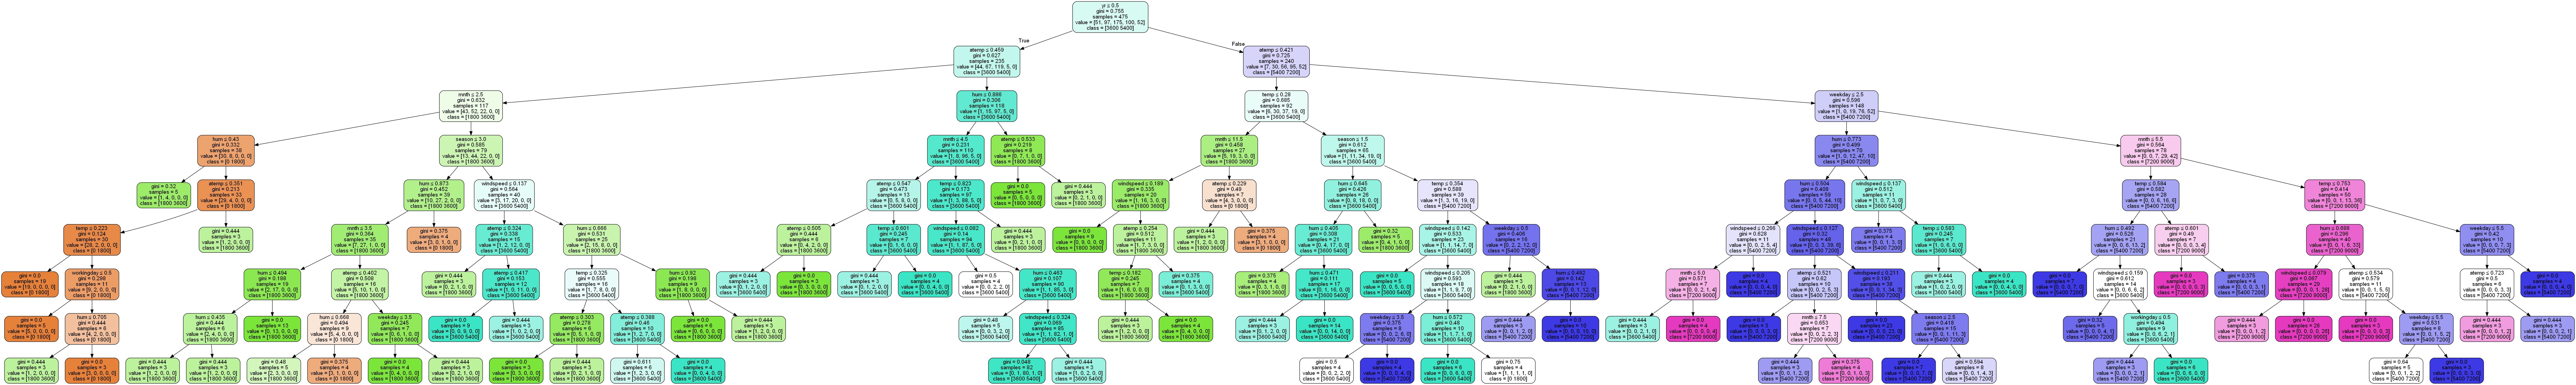

In [10]:
# Execution of 1a
prominent_features = main_ex_1a(classes, file_path)
# display tree graph
Image(os.path.join("images", "1_a_decision_tree_graphivz.png"))

Grad Desc Parameters:  {'alpha': 0.1, 'average': False, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'epsilon_insensitive', 'max_iter': 100000, 'n_iter_no_change': 5, 'penalty': 'l1', 'power_t': 0.25, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 1, 'warm_start': False}
Score: -5.374779245374733

Grad Desc Parameters:  {'alpha': 0.01, 'average': False, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'epsilon_insensitive', 'max_iter': 100000, 'n_iter_no_change': 5, 'penalty': 'l1', 'power_t': 0.25, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 1, 'warm_start': False}
Score: -2.718476407774252

Grad Desc Parameters:  {'alpha': 0.001, 'average': False, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, '

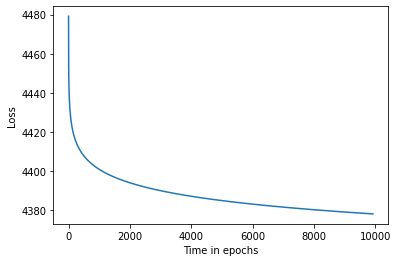

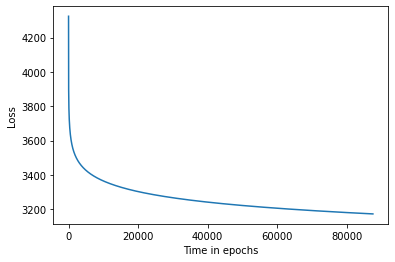

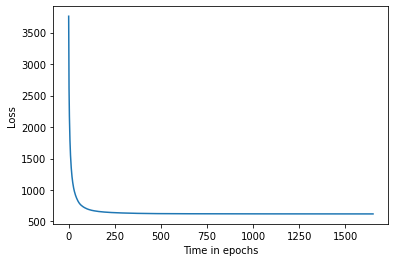

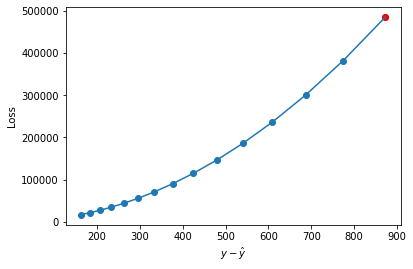

In [11]:
# Number of epochs to be used in question 1b, for the single instance error loss plotting.
epochs_b = 15
# Execution of 1b
main_ex_1b(file_path, prominent_features, epochs_b)

Bins used for binary classification: [0, 4500, 9000]
Best Parameters:  {'alpha': 0.1, 'loss': 'log', 'max_iter': 2000, 'penalty': 'l2'}
Best Accuracy Score Achieved in Grid Search:  0.8800000000000001


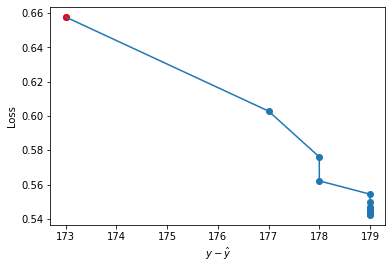

In [12]:
# Number of epochs to be used in question 1C, for the error loss plotting
epochs_c = 15
main_ex_1c(file_path, prominent_features, epochs_c)
